In [1]:
from sklearn import model_selection, linear_model, metrics, datasets

import numpy as np
import pandas as pd
import unittest
import sys
import matplotlib.pylab as plt

#### Загрузка данных

In [2]:
raw_data = pd.read_csv('Data_tests.csv', header = 0, sep=',')
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
raw_data.datetime = pd.to_datetime(raw_data['datetime'])

In [4]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
print('NULL status:', raw_data.isnull().values.any())
raw_data.info()

NULL status: False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


#### Добавление признака месяца и времени

In [6]:
raw_data['month'] = raw_data.datetime.apply(lambda x: x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x: x.hour)

#### Обчуение и тест

In [7]:
train_data = raw_data.iloc[:-1000, :]
test_data = raw_data.iloc[-1000:, :]

In [8]:
class MyExc(Exception):
    def __init__(self, string):
        print('У нас возникла проблема с :')
        print(string)
        a = input('Введите F чтобы продолжить выполнение')
        if a == 'F':
            pass
        else:
            sys.exit()

try:
    if list(train_data.shape)[0]+list(test_data.shape)[0] != list(raw_data.shape)[0]:
        raise MyExc("Размер суммы теста и обучения не совпадает с исходным размером выборки")
except MyExc:
    pass



In [9]:
print('Train Period')
print('train period form {} to {}'.format(train_data.datetime.min(), train_data.datetime.max()))
print('test period from {} to {}'.format(test_data.datetime.min(), test_data.datetime.max()))

Train Period
train period form 2011-01-01 00:00:00 to 2012-10-16 06:00:00
test period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


#### Данные и целевая метка

In [10]:
train_labels = train_data['count'].values
train_information = train_data.drop(['count','datetime'], axis=1)

In [11]:
test_labels = test_data['count'].values
test_information = test_data.drop(['count', 'datetime'], axis=1)
### Уберем лишние признаки
train_information.drop(['casual', 'registered'], axis=1, inplace=True)
test_information.drop(['casual', 'registered'], axis=1, inplace=True)

Text(0.5, 1.0, 'Test Labels')

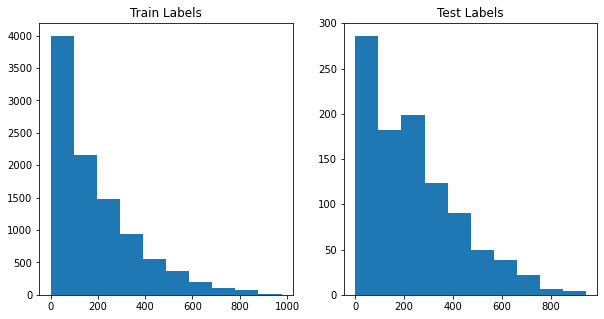

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(train_labels, bins=10)
plt.title('Train Labels')
plt.subplot(1,2,2)
plt.hist(test_labels)
plt.title('Test Labels')

In [13]:
# Бинарные признаки
binary_data_columns = ['holiday', 'workingday']
def includes_array(data, index):
    return list([(column in index) for column in data.columns])

binary_data_indices = np.array(includes_array(train_information, binary_data_columns))

In [14]:
# Категориальные признаки
categorial_data_columns = ['season', 'weather', 'month']
categorial_data_indices = np.array(includes_array(train_information, categorial_data_columns))


In [15]:
# Числовые признаки
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']
numeric_data_indices = np.array(includes_array(train_information, numeric_data_columns))

print(binary_data_indices)
print(categorial_data_indices)
print(numeric_data_indices)

[False  True  True False False False False False False False]
[ True False False  True False False False False  True False]
[False False False False  True  True  True  True False  True]


#### Сборка Pipeline

In [16]:
from sklearn import pipeline
from sklearn import preprocessing
regressor = linear_model.SGDRegressor(random_state=0, max_iter=3, loss='squared_loss', penalty='l2')

estimator = pipeline.Pipeline(steps=[
    ('feature_processing', pipeline.FeatureUnion(transformer_list=[
        #binary
        ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data.iloc[:, binary_data_indices])),
        #numeric
        ('numeric_variables_processing', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, numeric_data_indices])),
            ('scaling', preprocessing.StandardScaler(with_mean=0.)),
            ])),
        #categorial
        ('categorial_variables_processing', pipeline.Pipeline(steps=[
            ('selecting', preprocessing.FunctionTransformer(lambda data: data.iloc[:, categorial_data_indices])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore')),
            ])),
        ])),
    ('model_fitting', regressor),
    ]
)

In [32]:
print(categorial_data_indices)
#estimator.fit(train_information, train_labels)

[ True False False  True False False False False  True False]


In [18]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_information))

120.17177172806858

#### Подбор параметров

In [19]:
for _ in estimator.get_params().keys():
    print(_)

memory
steps
verbose
feature_processing
model_fitting
feature_processing__n_jobs
feature_processing__transformer_list
feature_processing__transformer_weights
feature_processing__verbose
feature_processing__binary_variables_processing
feature_processing__numeric_variables_processing
feature_processing__categorial_variables_processing
feature_processing__binary_variables_processing__accept_sparse
feature_processing__binary_variables_processing__check_inverse
feature_processing__binary_variables_processing__func
feature_processing__binary_variables_processing__inv_kw_args
feature_processing__binary_variables_processing__inverse_func
feature_processing__binary_variables_processing__kw_args
feature_processing__binary_variables_processing__validate
feature_processing__numeric_variables_processing__memory
feature_processing__numeric_variables_processing__steps
feature_processing__numeric_variables_processing__verbose
feature_processing__numeric_variables_processing__selecting
feature_processi

In [20]:
params_grid = {
    'model_fitting__eta0' : [0.001, 0.05],
    'model_fitting__alpha' : [0.0001, 0.001, 0.1],
}
scorer = metrics.make_scorer(score_func=metrics.mean_absolute_error)
grid_cv = model_selection.GridSearchCV(estimator, params_grid, scoring=scorer,
cv=4)
grid_cv.fit(train_information, train_labels)

/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/molozey/PycharmProjects/Coursera_Machine_2/venv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:1220: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/molozey/PycharmProjects/Course

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables_processing',
                                                                        FunctionTransformer(func=<function <lambda> at 0x124305670>)),
                                                                       ('numeric_variables_processing',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x124305550>)),
                                                                                        ('scaling',
                                                                                         StandardScaler(with_mean=0.0))])),
                                                                       ('categorial_variables_proce

In [21]:
grid_cv.best_estimator_
grid_cv.best_score_

111.87846716526332

In [22]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_information))

122.998863816993

#### Затравка на случайный лес

In [23]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
regressor = RandomForestRegressor(random_state=0, max_depth=20, n_estimators=20)

In [25]:
estimator = pipeline.Pipeline(steps=[
    ('feature_processing', pipeline.FeatureUnion(transformer_list=[
        #binary
        ('binary_values_process', preprocessing.FunctionTransformer(lambda data: data.iloc[:, binary_data_indices])),
        #categorial
        ('categorial_values_process', pipeline.Pipeline(steps=[
            ('selection', preprocessing.FunctionTransformer(lambda data: data.iloc[:, categorial_data_indices])),
            ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown='ignore')),
                ])),
        #numbers
        ('num_value_process', pipeline.Pipeline(steps=[
            ('selection', preprocessing.FunctionTransformer(lambda data: data.iloc[:, numeric_data_indices])),
            ('scaling', preprocessing.StandardScaler(with_mean=0., with_std=1.)),
                ])),
    ])),
    ('model_fitting', regressor),
])

In [26]:
estimator.fit(train_information, train_labels)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_values_process',
                                                 FunctionTransformer(func=<function <lambda> at 0x124140940>)),
                                                ('categorial_values_process',
                                                 Pipeline(steps=[('selection',
                                                                  FunctionTransformer(func=<function <lambda> at 0x124140af0>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore'))])),
                                                ('num_value_process',
                                                 Pipeline(steps=[('selection',
                                                                  FunctionTransformer(func=<function <lambda> at 0x124140ca0>)),
                   

In [27]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_information))

79.03952916983812

In [28]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446])

In [29]:
estimator.predict(test_information)[:10]

array([410.5125    , 450.55      , 246.04      , 166.16803571,
       212.68011905, 235.46529729, 227.41005919, 305.99032615,
       273.35807507, 409.725     ])

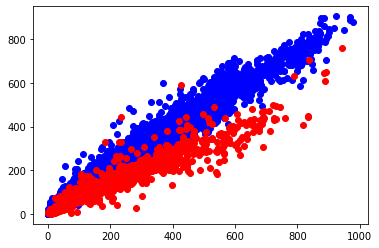

In [30]:
plt.scatter(train_labels,estimator.predict(train_information), color = 'blue')
plt.scatter(test_labels, estimator.predict(test_information), color='red')